# Reviews analysis on European Luxury Hotels

# 0. Background and Introduction

Whether hotel managers like it or not, guest reviews are becoming an essential factor influencing people's booking/purchase. Think about our past experiences. When we are looking for vacation accommodation on Booking.com, we may unknowingly scroll down the screen to view reviews.

As reviews become more and more important, hotel owners need to start using them. The analysis of reviews can help hotels understand what customers think about themselves and understand whether the hotel meets customer expectations. This analysis can also contribute to building up user portraits based on the reviews, which is essential for formulating marketing strategies based on the role of the customer. In addition, hotels can also compare themselves with similar hotels in the same region to measure their competitiveness and better locate themselves.

The review on Booking.com has a significant feature. Reviewers should give positive and negative feelings separately when writing, as shown in the figure. For potential customers, this can help them better decide which hotel to choose. For owners, this can better help estimate customers' overall rating of the hotel through review text.

fig.1 - Reviewing process on Booking.com

This report will focus on luxury hotels in six famous European tourism nations and analyze their reviews on Booking.com. The analysis will mainly involve and try to answer these questions: What do customers care about hotels in different countries? Are customers' reviews of each hotel positive or negative? How to predict the guest's rating based on hotels' basic information, the reviewers' information, and their text evaluations? How to classify and locate hotels based on their ratings and reviews. How to cluster consumers and roughly describe their portraits?

## 1. Data loading and wrangling

In [535]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import geoviews as gv
import geoviews.tile_sources as gvts
import hvplot.pandas
import holoviews as hv
import seaborn as sns
import altair as alt

np.random.seed(42)

palette5 = ["#61a262","#1a7328","#f2b4ae","#f26a4b","#f25d50"]
palette4 = ["#61a262","#1a7328","#f2b4ae","#f25d50"]
palette2 = ["#61a262","#f26a4b"]


### Load hospital reviews data with API 

Set up environment variable for kaggle API.

In [536]:
# set Kaggle key to environment variable
os.environ["KAGGLE_USERNAME"] = "lanxiao1120"
os.environ["KAGGLE_KEY"] = "dc6f594f7f5b866e3aec880f88948cb8"

# !!users need to install kaggle package first
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

Load data from Kaggle with API.

In [537]:
#Signature: dataset_download_file(dataset, file_name, path=None, force=False, quiet=True)
# download file via API
api.dataset_download_file('jiashenliu/515k-hotel-reviews-data-in-europe','Hotel_Reviews.csv', path='data')
# read it
hotel_raw = pd.read_csv('data/Hotel_Reviews.csv.zip')

#hotel_raw.head()

### Wrangle data and join with country Boundaries

Transform data into geo data frame, transform date columns into date type, and trim data into those of 2016.

In [538]:
# set up coord
hotel = hotel_raw.copy()
hotel['geometry'] = gpd.points_from_xy(hotel['lng'], hotel['lat'])

# to geo df
hotel = gpd.GeoDataFrame(hotel, geometry="geometry", crs="EPSG:4326")

# convert crs to 3857
hotel = hotel.to_crs(epsg=3857)

# transform to date
hotel['Review_Date'] = pd.to_datetime(hotel['Review_Date'] ,format='%m/%d/%Y')

# trim into 2016
hotel = hotel.loc[hotel['Review_Date'] >= '2016-01-01']
hotel = hotel.loc[hotel['Review_Date'] < '2017-01-01']

hotel.head(n=2)

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng,geometry
66,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,2016-12-29,7.7,Hotel Arena,United Kingdom,Asked for more coffee and sugars only got giv...,40,1403,Nice open room Bed plenty of room Bath room c...,28,7,9.2,"[' Leisure trip ', ' Couple ', ' Large King Ro...",217 day,52.360576,4.915968,POINT (547243.088 6865586.634)
67,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,2016-12-28,7.7,Hotel Arena,South Africa,Room was not cleaned correctly Wine Champagne...,30,1403,To begin with we were upgraded which made my ...,92,6,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",218 day,52.360576,4.915968,POINT (547243.088 6865586.634)


In [539]:
%%opts WMTS [width=800, height=800, xaxis=None, yaxis=None]

hotel_2017 = hotel.loc[hotel['Review_Date']>'2017-01-01']

#hotel_2017.hvplot(geo=True, tiles=True, crs=3857)

Load data of European countries, and spatial join with hotel data.

In [540]:
# get country data 
url = 'https://gisco-services.ec.europa.eu/distribution/v2/countries/geojson/CNTR_RG_01M_2020_3857.geojson'
country = gpd.read_file(url)
#select col
country = country[['NAME_ENGL','geometry']]
# spatial join
hotel_joined = gpd.sjoin(hotel, country, op='within', how='left').drop(['index_right'], axis=1)


Change the name of the column for country.

In [541]:
# change column name
hotel_joined = hotel_joined.rename(
    columns={"NAME_ENGL": "Country"}
)

hotel_joined.head(n=2)

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng,geometry,Country
66,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,2016-12-29,7.7,Hotel Arena,United Kingdom,Asked for more coffee and sugars only got giv...,40,1403,Nice open room Bed plenty of room Bath room c...,28,7,9.2,"[' Leisure trip ', ' Couple ', ' Large King Ro...",217 day,52.360576,4.915968,POINT (547243.088 6865586.634),Netherlands
67,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,2016-12-28,7.7,Hotel Arena,South Africa,Room was not cleaned correctly Wine Champagne...,30,1403,To begin with we were upgraded which made my ...,92,6,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",218 day,52.360576,4.915968,POINT (547243.088 6865586.634),Netherlands


## 2. Exploratory analysis

##  3. Words frequency analysis & Interactive word clouds

What are the most commonly used words in hotel reviews? Analyzing it can help hotel owners understand the most valuable services that reviewers care about. 

So let's start with the comprehensive data. After removing the meaningless pause words, the four most common terms are in order: room, staff, location, and breakfast, which represent the four fields consumers care about most about hotel accommodation.

### Lower and split reviews

In [542]:
hotel_review = hotel_joined.copy()

hotel_review['Negative_Review'] = [review.lower().split() for review in hotel_review['Negative_Review']]
hotel_review['Positive_Review'] = [review.lower().split() for review in hotel_review['Positive_Review']]

### Remove stop words and punctuation

Load stop words and create a list.

In [543]:
import nltk
# download stop words
nltk.download('stopwords');

#Get the list of common stop words
stop_words = list(set(nltk.corpus.stopwords.words('english')))

[nltk_data] Downloading package stopwords to /Users/lexi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Load common punctuation and create a list.

In [544]:
import string

punctuation = list(string.punctuation)

Remove stop words and punctuation from our reviews.

In [545]:
# list to remove
ignored = stop_words + punctuation

# Remove from each review column
hotel_review['Negative_Review'] = [[word for word in review if word not in ignored]
              for review in hotel_review['Negative_Review']]
hotel_review['Positive_Review'] = [[word for word in review if word not in ignored]
              for review in hotel_review['Positive_Review']]

### Count word frequencies first time

Create a new column containing both positive review and negative review.

In [546]:
hotel_review['Total_Review'] = pd.concat([hotel_review['Negative_Review'],hotel_review['Positive_Review']], 
                                         ignore_index=True)

hotel_review.head(n=2)

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng,geometry,Country,Total_Review
66,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,2016-12-29,7.7,Hotel Arena,United Kingdom,"[asked, coffee, sugars, got, given, two, satch...",40,1403,"[nice, open, room, bed, plenty, room, bath, ro...",28,7,9.2,"[' Leisure trip ', ' Couple ', ' Large King Ro...",217 day,52.360576,4.915968,POINT (547243.088 6865586.634),Netherlands,"[would, nice, one, responsible, cleaning, room..."
67,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,2016-12-28,7.7,Hotel Arena,South Africa,"[room, cleaned, correctly, wine, champagne, gl...",30,1403,"[begin, upgraded, made, wife, happy, room, spa...",92,6,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",218 day,52.360576,4.915968,POINT (547243.088 6865586.634),Netherlands,"[first, impressions, dark, reception, made, us..."


Define a helper function to calculate word frequencies from our data frame with other information.

In [547]:
def count_word(review_col, top=20):
    """
    Given a column of all words for every rhotel, count word frequencies across all reviews.
    
    By default, this returns the top 20 words, but you can specify a different value for `top`.
    """
    import itertools, collections
    
    # List of all words across hotels
    all_words = list(itertools.chain(*review_col))

    # Create counter
    counter = collections.Counter(all_words)
    
    return pd.DataFrame(counter.most_common(top),
                        columns=['words', 'count'])

In [548]:
counts_reviews = count_word(hotel_review['Total_Review'], top=20)
counts_reviews

,words,count
0,room,81858
1,staff,60017
2,location,52072
3,hotel,49687
4,breakfast,37343
5,good,34250
6,negative,33003
7,great,30074
8,friendly,22985
9,bed,21364


### Remove words that are not helpful

Remove words that are not very helpful for analysis.

In [549]:
neutral_words = ["nothing", "hotel", "would","could","one","bit","little","us","get","time","really","also","even"]
hotel_review['Total_Review'] = [[word for word in review if word not in neutral_words]
              for review in hotel_review['Total_Review']]

### Count words frequency for the final cleaned reviews

In [550]:
counts_reviews = count_word(hotel_review['Total_Review'], top=20)
counts_reviews

,words,count
0,room,81858
1,staff,60017
2,location,52072
3,breakfast,37343
4,good,34250
5,negative,33003
6,great,30074
7,friendly,22985
8,bed,21364
9,helpful,20890


Plot the words frequency result.

In [551]:
"""
fig, ax = plt.subplots(figsize=(8, 8))

sns.barplot(
    y="words",
    x="count",
    data=counts_reviews.sort_values(by="count", ascending=False),
    ax=ax,
    color=palette4[2],
    saturation=1.0,
)

ax.set_title("Common Words Found in Hotel Reviews (Without Stop Words)", fontsize=16);
"""

'\nfig, ax = plt.subplots(figsize=(8, 8))\n\nsns.barplot(\n    y="words",\n    x="count",\n    data=counts_reviews.sort_values(by="count", ascending=False),\n    ax=ax,\n    color=palette4[2],\n    saturation=1.0,\n)\n\nax.set_title("Common Words Found in Hotel Reviews (Without Stop Words)", fontsize=16);\n'

### Define functions to plot word clouds from word frequency

However, the focus does vary with the country and its tourism characteristics. So an interactive word cloud is made by the country and the largest number of words to show. 

As the results show, people are most concerned about the location and staff services in the Netherlands, Italy, Spain, and Austria, and there are more positive words in the evaluation (good, great, friendly, Etc.). In the UK, people are more concerned about rooms conditions and staff services, and the frequency of 'negative' is higher in reviews. In France, people pay more attention to rooms and breakfast, and negative words (negative, small, Etc.) appear more frequently. 

What's more, each country has its unique characteristics. For example, reviewers in France pay more attention to the night experience and shower experience.

In [552]:
import multidict as multidict
import numpy as np
import os
import re
from PIL import Image
from os import path
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import itertools, collections


def getFrequencyDictForText(sentence): 
    
    """
    Given a list of all words from all reviews, count word frequencies across all reviews, 
    return a dictionary of word and frequency.
    
    """

    # get frequency
    fullTermsDict = multidict.MultiDict()
    tmpDict = {}

    # making dict for counting frequencies
    for text in sentence.split(" "):
        if re.match("a|the|an|the|to|in|for|of|or|by|with|is|on|that|be", text):
            continue
        val = tmpDict.get(text, 0)
        tmpDict[text.lower()] = val + 1
    for key in tmpDict:
        fullTermsDict.add(key, tmpDict[key])
    return fullTermsDict


def plot_cloud(Country, df=hotel_review, select_col='Country', text_col='Total_Review', Maximum=[20,50,100,150], title="Most used words in reviews by country"):
    """
    Given a dataframe, the column to interact with, the column with review text, 
    selected the country to analyze, maxmium word to display, title to show,
    generate a word cloud.
    
    """
        
    # select country 
    df_filtered = df.loc[df[select_col]==Country]
    # put all review words into one string object.
    all_words_list = list(itertools.chain(*df_filtered[text_col]))
    all_words = ''
    for word in all_words_list:
        all_words += " " + word
    
    # load base pic
    #alice_mask = np.array(Image.open("image/europe.png"))

    # set up word clooud
    wc = WordCloud(background_color="white", 
                   max_words=Maximum,
                   width=1500,       
                   height=960,          
                   margin=10)
    
    # generate word cloud
    wc.generate_from_frequencies(getFrequencyDictForText(all_words))
    
    # show
    fig, ax = plt.subplots(figsize=(15, 10))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=40,fontweight="bold")
    plt.figure()
    

### Implement interactivity

Obtain a list of all countries.

In [553]:
list1 = list(hotel_review['Country'].unique())

# remove nan
list1 = list1[0:3]+list1[4:7]

list2 = [20,50,100,150]

list1

['Netherlands', 'United Kingdom', 'France', 'Spain', 'Austria', 'Italy']

The default panel import.

In [554]:
# Load panel and enable interactive features
import panel as pn
pn.extension()

Interact Functions.

Row
    [0] Column
        [0] Markdown(str)
        [1] Column
            [0] Select(name='Country', options=['Netherlands', ...], value='Netherlands')
            [1] DiscreteSlider(formatter='%d', name='Maximum', options=[20, 50, 100, 150], value=20)
    [1] Row
        [0] Str(None, name='interactive31630')

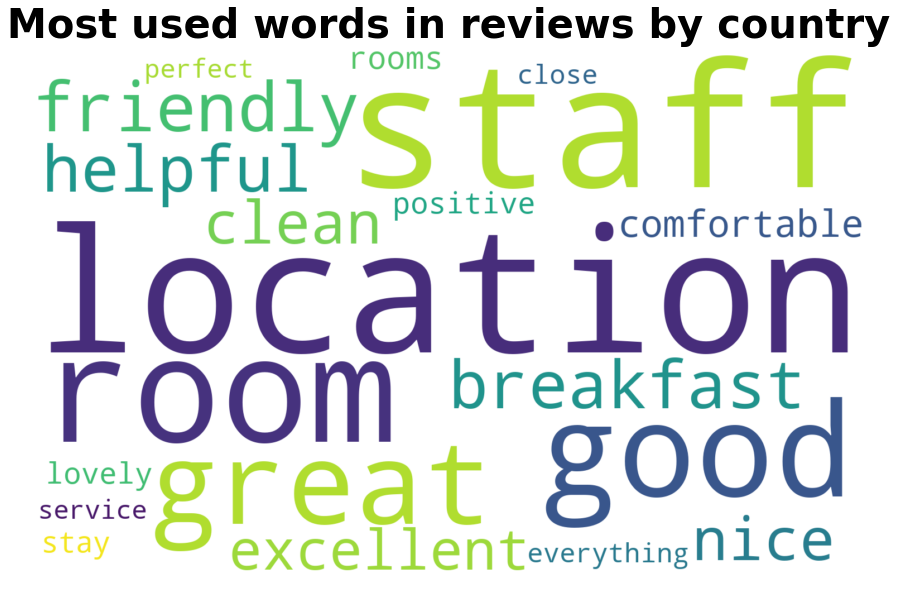

<Figure size 432x288 with 0 Axes>

In [555]:
# Auto-generate the layout
layout = pn.interact(plot_cloud, Country=list1, Maximum=list2)

# Create the dashboard with a Row and Column
interact_dashboard = pn.Row(pn.Column('## MPG Explorer', layout[0]), layout[1])
interact_dashboard